Based on labelled data from cluster analysis, this code block performs comparison of 2 models with and without test augmentation.

- BiLSTM without text augmentation
- Transformer Encoder without text augmentation
- BiLSTM with text augmentation: x3, x4, x8, x12, x16
- Transformer Encoder with text augmentation: x3, x4, x8, x12, x16

Reference of text augmentation

@inproceedings{wei-zou-2019-eda,
    title = "{EDA}: Easy Data Augmentation Techniques for Boosting Performance on Text Classification Tasks",
    author = "Wei, Jason  and
      Zou, Kai",
    booktitle = "Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP)",
    month = nov,
    year = "2019",
    address = "Hong Kong, China",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/D19-1670",
    pages = "6383--6389",
}

# Load

In [1]:
# for processing
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import re
import string # remove punctuation
import json
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from time import time

# for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pydot, graphviz


# for BOW and metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer as TFIDF
from sklearn import feature_extraction, feature_selection, model_selection, pipeline, manifold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# for word embedding
import gensim # w2v d2v
import gensim.downloader as gensim_api

# for upsampling
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# for clustering analysis (performed in R)
#import scipy.cluster.hierarchy as sch

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# for ML models
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.calibration import CalibratedClassifierCV

# metrics
from sklearn.metrics import brier_score_loss as BS
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import silhouette_samples, silhouette_score

# for DL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import plot_model
import keras.backend as K
import tensorflow_addons as tfa # cohen_kappa is in tf addons
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.models import Sequential

# for bert language model
#import transformers

# Utils

In [314]:
storage = {}

# initial clean
def util_initialclean_text(text):
    text = re.sub('byby', 'by', str(text).lower().strip())
    text = re.sub('by by', 'by', str(text).lower().strip())
    text = re.sub('threexten', 'three times ten', str(text).lower().strip())
    text = re.sub('fivexfive', 'five times five', str(text).lower().strip())
    text = re.sub('fivexthree', 'five times three', str(text).lower().strip())
    text = re.sub('fivextwo', 'five times two', str(text).lower().strip())
    text = re.sub('fivexsix', 'five times six', str(text).lower().strip())
    text = re.sub('twoxfour', 'two times four', str(text).lower().strip())
    text = re.sub('twoxsix', 'two times six', str(text).lower().strip())
    text = re.sub('tenxtwo', 'ten times two', str(text).lower().strip())
    text = re.sub('tenxten', 'ten times ten', str(text).lower().strip())
    text = re.sub('thirteenxzero', 'thirteen times zero', str(text).lower().strip())
    text = re.sub('thirteenxtwo', 'thirteen times two', str(text).lower().strip())
    text = re.sub('thirteenxone', 'thirteen times one', str(text).lower().strip())
    text = re.sub('fifteenx', 'fifteen times', str(text).lower().strip())
    text = re.sub('onex', 'one times', str(text).lower().strip())
    text = re.sub('ninetyxtwo', 'ninety times two', str(text).lower().strip())
    text = re.sub('twoxsquare', 'two times square', str(text).lower().strip())
    text = re.sub('seventeenxsixty', 'seventeen times sixty', str(text).lower().strip())
    text = re.sub('squareroot', 'square root', str(text).lower().strip())
    text = re.sub('squarerootnine', 'square root nine', str(text).lower().strip())
    text = re.sub('rootnine', 'root nine', str(text).lower().strip())
    text = re.sub('twosquared', 'two squared', str(text).lower().strip())
    text = re.sub('_', '', str(text).lower().strip())
    text = re.sub('timesone', 'times one', str(text).lower().strip())
    text = re.sub('befriend', 'be friend', str(text).lower().strip())
    text = re.sub('timesfive', 'times five', str(text).lower().strip())
    text = re.sub('threextwo', 'three times two', str(text).lower().strip())
    text = re.sub('divied', 'divided', str(text).lower().strip())
    text = re.sub('ppoint', 'point', str(text).lower().strip())
    text = re.sub('timesthree', 'times three', str(text).lower().strip())
    text = re.sub('threehi', 'three', str(text).lower().strip())
    text = re.sub('fived', 'five', str(text).lower().strip())
    text = re.sub('fourty', 'forty', str(text).lower().strip())
    return text

def recall_rnn(Ytest, y_pred):
    tp = K.sum(K.round(K.clip(Ytest * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(Ytest, 0, 1)))
    recall = tp / (possible_positives + K.epsilon())
    return recall

def precision_rnn(Ytest, y_pred):
    tp = K.sum(K.round(K.clip(Ytest * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (predicted_positives + K.epsilon())
    return precision

# preprocess to list of words
def util_preprocess_to_list(text, rm_stopwords=True, stem=False, lemm=False):
    # define
    ps = PorterStemmer()
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    stop_words = stopwords.words('english')
    stop_words.remove('a')
    
    text = text.strip()
    # remove punctuation
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    #tokens = re.split('\W+', text) # alternative
    
    #stems = [ps.stem(w) for w in text.split(' ')]
    if rm_stopwords == True:
        tokens = [word for word in tokens if word not in stop_words]
    if stem == True:
        #text = [word for word in stems if word not in stop_words]
        tokens = [ps.stem(word) for word in tokens]
    if lemm == True:
        tokens = [lem.lemmatize(word) for word in tokens]
    
    return tokens # return a list of words, not sentence

# preprocess to sentence
# remove punctuations, strip, lower, lemmatization, no stemming, no stopwords removal
def util_preprocess_to_sentence(text, rm_stopwords=True, stem=False, lemm=False):
    # define
    ps = PorterStemmer()
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    stop_words = stopwords.words('english')
    stop_words.remove('a')

    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    lst_text = text.split()
    
    if stopwords == True:
        lst_text = [word for word in lst_text if word not in stop_words]
    if stem == True:
        lst_text = [ps.stem(word) for word in lst_text]
    if lemm == True:
        lst_text = [lem.lemmatize(word) for word in lst_text]
    
    # to sentence
    text = ' '.join(lst_text)
    
    return text # return a complete sentence, not in list
    #return lst_text
    
# plot metrics
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs", fontsize=10)
    plt.ylabel(metric, fontsize=12)
    plt.legend([metric, 'val_'+metric], fontsize=12)

# implement a Transformer block as a layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    

# implement embedding layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim) # , mask_zero=True
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]


# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    
    for (idx, c_label) in enumerate(targetlabel):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
    

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

   # plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=12)
        plt.yticks(tick_marks, target_names, fontsize=12)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=12)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=12)


    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=14)
    plt.show()

# Data & parameters

In [3]:
df3_new = pd.read_csv('./log/df3_newfeature_cluster.csv')
df3_new['concat'] = df3_new['concat'].apply(lambda x: util_initialclean_text(x))
df3_new['clean_text'] = df3_new['concat'].apply(lambda x: util_preprocess_to_sentence(x, rm_stopwords=False
                                                                             ,stem=False, lemm=True
                                                                            ))
#df3_new.to_csv('./log/df3_new_cluster3.csv', index=False)
df3_new.head()

,ID,Judge1,Judge2,Judge3,Judge4,Mean.Rating,concat,clean_text,lod,mr_scaled,lod_scaled,cluster_km
0,37009,3.0,3,4.000000,3.0,3.250000,thirteen times thirteen equals one hundred six...,thirteen time thirteen equal one hundred sixty...,0.500000,1.467478,-0.936729,1
1,37491,2.0,1,3.000000,1.0,1.750000,five plus eight sixteen minus three seventeen ...,five plus eight sixteen minus three seventeen ...,0.957427,-0.504228,0.193149,4
2,38002,2.0,1,3.000000,2.0,2.000000,six plus seven minus seven plus six minus two ...,six plus seven minus seven plus six minus two ...,0.816497,-0.175610,-0.154960,4
3,38905,4.0,2,2.333333,1.0,2.333333,eight times one to the power of zero times two...,eight time one to the power of zero time two h...,1.247219,0.262546,0.908956,4
4,38930,3.0,2,3.000000,NaN,2.666667,open bracket ten plus three close bracket mult...,open bracket ten plus three close bracket mult...,0.577350,0.700703,-0.745669,1


25.49433106575964


<AxesSubplot:ylabel='Frequency'>

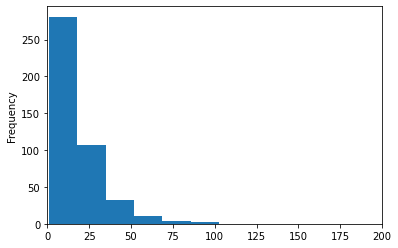

In [4]:
print(df3_new.clean_text.apply(lambda x: len(x.split(" "))).mean())
df3_new.clean_text.apply(lambda x: len(x.split(" "))).plot(kind='hist', bins=100, xlim=(0, 200))

Padded length: 50
Output activation: softmax
vocab_size: 573
X shape: (441, 50) 
 4    231
2     95
1     61
3     54
Name: cluster_km, dtype: int64


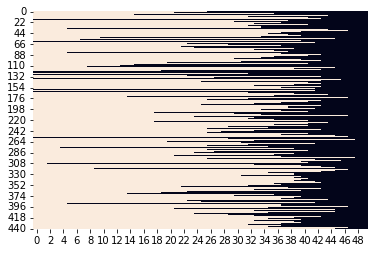

x_train shape: (352, 50)	y_train shape: (352, 4)
x_test shape: (89, 50)	y_test shape: (89, 4)



In [357]:
# Set parameters
maxlen = 50
act_output = 'softmax' # multiclass
print('Padded length: {}\nOutput activation: {}'.format(maxlen, act_output))

# get tokenizer
max_vocab_size = 2000
tokenizer = Tokenizer(num_words=max_vocab_size, lower=True, oov_token=True)
tokenizer.fit_on_texts(df3_new['clean_text'])
vocab_size = len(tokenizer.index_word)
print('vocab_size:', vocab_size)

# get X
X_seq = tokenizer.texts_to_sequences(df3_new['clean_text'].values)
X = pad_sequences(X_seq, maxlen)

# get Y
Y = pd.get_dummies(df3_new['cluster_km']).values
print('X shape:', X.shape, '\n', df3_new['cluster_km'].value_counts())

sns.heatmap(X==0, vmin=0, vmax=1, cbar=False)
plt.show()

# split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=420)
print('x_train shape: {}\ty_train shape: {}\nx_test shape: {}\ty_test shape: {}\n'.format(
    x_train.shape, y_train.shape, x_test.shape, y_test.shape))

# prepare for maping from cluster labels [1,2,3,4] to target labels
labels = np.argmax(y_test, axis=1)
targetlabel = ['agreedMidHigh', 'agreedLow', 'arguablyHigh','average']

In [6]:
print(df3_new['clean_text'][1])
print(X_seq[1])
print(X[1])

five plus eight sixteen minus three seventeen minus four eighteen minus five
[14, 2, 23, 61, 5, 8, 62, 5, 16, 68, 5, 14]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  2 23 61  5  8 62  5 16 68
  5 14]


# Model - Bidirectional LSTM

In [9]:
threshold = 0.4
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_cohen_kappa') > threshold):
            print("\nReached %2.2f%% kappa, so stopping training!!" %(threshold*100))
            self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

In [10]:
embed_dim = 4 # shape(x) = 4

m_rlstm = Sequential()
m_rlstm.add(Embedding(vocab_size+1, output_dim=embed_dim, input_length=maxlen))
m_rlstm.add(Bidirectional(LSTM(64)))
m_rlstm.add(Dense(64, activation='relu'))
m_rlstm.add(Dense(4, activation='softmax'))

# compile
m_rlstm.compile(optimizer='adam' # Adam(learning_rate=0.0005) 
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy', tfa.metrics.F1Score(num_classes=4, average='weighted')
                             , tfa.metrics.CohenKappa(num_classes=4)])
print(vocab_size, embed_dim, maxlen)
print(m_rlstm.summary())

# train
num_epoch = 30
time0=time()
history_rlstm = m_rlstm.fit(x_train, y_train, epochs=num_epoch
                      # , validation_steps=15
                       , validation_data=(x_test, y_test)
                            , callbacks=[callbacks]
                       )
timediff = time()-time0
print(timediff)

573 4 50
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 4)             2296      
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              35328     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 46,140
Trainable params: 46,140
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
11/11 [==============================] - 5s 127ms/step - loss: 1.3580 - accuracy: 0.4716 - 

3/3 [==============================] - 0s 10ms/step - loss: 0.9426 - accuracy: 0.6966 - f1_score: 0.6548 - cohen_kappa: 0.4116


(0.0, 0.4327074885368347)

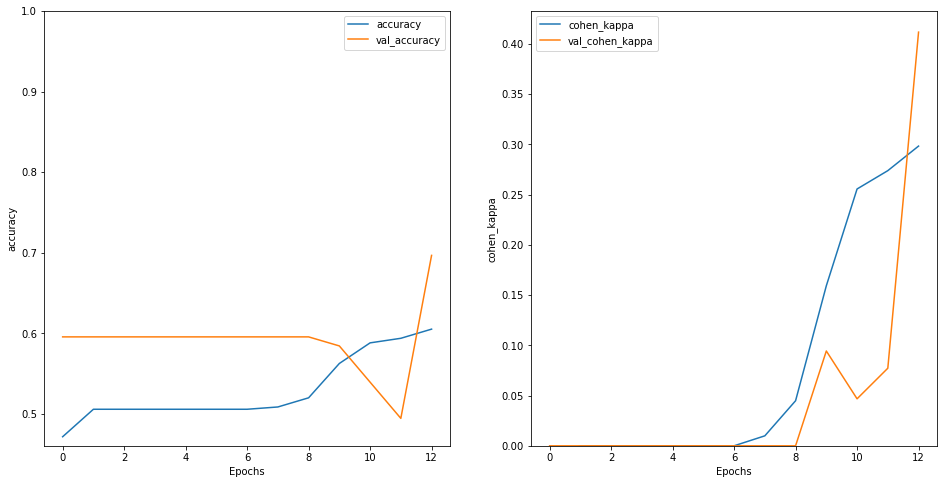

In [101]:
test_acc_rlstm = m_rlstm.evaluate(x_test, y_test)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_rlstm, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_rlstm, 'cohen_kappa')
plt.ylim(0, None)

In [131]:
# save this result
Model = 'BiLSTM'
config_name = 'Bidirectional LSTM, no text augmentation'

param = {'vocab_size': vocab_size, 'embed_dim':embed_dim
         , 'maxlen':maxlen, 'num_aug': 'None'}
results = {'Loss':test_acc_rlstm[0], 'Accuracy':test_acc_rlstm[1], 'F1':test_acc_rlstm[2], 'Kappa':test_acc_rlstm[3]}
storage.update({Model: {'config':config_name, 'parameters':param, 'duration':timediff, 'results': results}})

print(storage.keys())
list(storage.items())

dict_keys(['BiLSTM_aug_3', 'TransformerEncoder', 'BiLSTM'])


[('BiLSTM_aug_3',
  {'config': 'num_aug = 3',
   'parameters': {'vocab_size': 1040,
    'embed_dim': 4,
    'maxlen': 50,
    'num_aug': 3},
   'duration': 16.601496696472168,
   'results': {'Loss': 0.8465606570243835,
    'Accuracy': 0.7142857313156128,
    'F1': 0.7033319473266602,
    'Kappa': 0.5093098878860474}}),
 ('TransformerEncoder',
  {'config': 'Transformer Encoder, no text augmentation',
   'parameters': {'vocab_size': 1040,
    'embed_dim': 4,
    'maxlen': 50,
    'num_aug': 'None'},
   'duration': 16.601496696472168,
   'results': {'Loss': 0.9209188222885132,
    'Accuracy': 0.6966292262077332,
    'F1': 0.6611249446868896,
    'Kappa': 0.4273117780685425}}),
 ('BiLSTM',
  {'config': 'Bidirectional LSTM, no text augmentation',
   'parameters': {'vocab_size': 1040,
    'embed_dim': 4,
    'maxlen': 50,
    'num_aug': 'None'},
   'duration': 16.601496696472168,
   'results': {'Loss': 0.9426203370094299,
    'Accuracy': 0.6966292262077332,
    'F1': 0.6547823548316956,
    

In [17]:
pred = m_rlstm.predict(x_test)
label_pred_rlstm = np.argmax(pred, axis=1)
cm_rlstm = confusion_matrix(y_true=labels, y_pred=label_pred_rlstm, labels=[0,1,2,3])
report_rlstm = classification_report(labels, label_pred_rlstm, labels=[0,1,2,3])
print('Confusion Matrix:\n', cm_rlstm, '\nClassification rreport:\n', report_rlstm)

Confusion Matrix:
 [[ 0  1  3  6]
 [ 0 11  1  9]
 [ 0  1  2  2]
 [ 0  1  3 49]] 
Classification rreport:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.79      0.52      0.63        21
           2       0.22      0.40      0.29         5
           3       0.74      0.92      0.82        53

    accuracy                           0.70        89
   macro avg       0.44      0.46      0.43        89
weighted avg       0.64      0.70      0.65        89



C:\Users\erwang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erwang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erwang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Due to small amount of testset size, there would be some cases that one class is not predicted with any value. A warning message will come out in such cases.

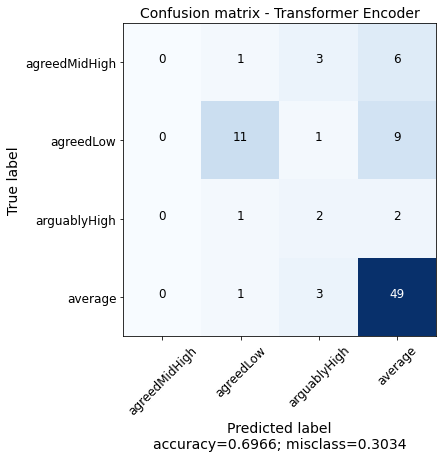

In [93]:
# plot confusion matrix
#fig, axes = plt.subplots(1,2, figsize=(16,10))
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_rlstm, target_names=targetlabel, title='Confusion matrix - Transformer Encoder', normalize=False)

ROC AUC score: 0.6560830778852421


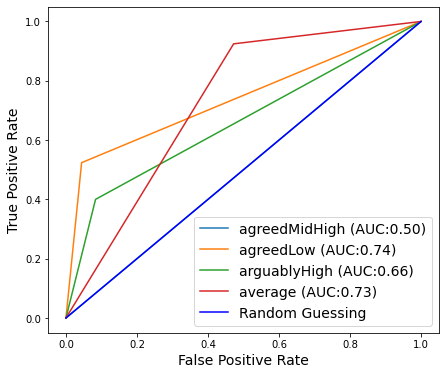

In [344]:
# plot AUC
fig, c_ax = plt.subplots(1,1,figsize = (7, 6))
auc_rlstm = multiclass_roc_auc_score(labels, label_pred_rlstm)
print('ROC AUC score:', auc_rlstm)
c_ax.legend(fontsize=14)
c_ax.set_xlabel('False Positive Rate', fontsize=14)
c_ax.set_ylabel('True Positive Rate', fontsize=14)
plt.show()

# Model - Transformer Encoder

In [96]:
embed_dim_ = 5  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size+1, embed_dim_) # embedding + positioning
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim_, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
#x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)

m_enc = keras.Model(inputs=inputs, outputs=outputs)

# train and evaluate
m_enc.compile(optimizer='adam' # Adam(learning_rate =0.0009) # , decay=0.00001
                     , loss="categorical_crossentropy"
                     , metrics=['accuracy'
                             , tfa.metrics.F1Score(num_classes=4, average='weighted')
                             , tfa.metrics.CohenKappa(num_classes=4)])
print(m_enc.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 token_and_position_embeddin  (None, 50, 5)            3120      
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 50, 5)            964       
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 5)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_8 (Dense)             (None, 32)                192   

In [97]:
num_epoch = 30
time0=time()
history_enc = m_enc.fit(x_train, y_train, epochs=num_epoch,
                          # , batch_size=batchsize
                    validation_steps=15,
                    validation_data=(x_test, y_test),
                       callbacks=[callbacks])
timediff = time()-time0
print(timediff)

Epoch 1/30
11/11 [==============================] - 3s 87ms/step - loss: 1.2869 - accuracy: 0.4915 - f1_score: 0.3339 - cohen_kappa: -0.0161 - val_loss: 1.0938 - val_accuracy: 0.5955 - val_f1_score: 0.4445 - val_cohen_kappa: 0.0000e+00
Epoch 2/30
11/11 [==============================] - 0s 13ms/step - loss: 1.2234 - accuracy: 0.5057 - f1_score: 0.3397 - cohen_kappa: 0.0000e+00 - val_loss: 1.1004 - val_accuracy: 0.5955 - val_f1_score: 0.4445 - val_cohen_kappa: 0.0000e+00
Epoch 3/30
11/11 [==============================] - 0s 13ms/step - loss: 1.2120 - accuracy: 0.5057 - f1_score: 0.3397 - cohen_kappa: 0.0000e+00 - val_loss: 1.0947 - val_accuracy: 0.5955 - val_f1_score: 0.4445 - val_cohen_kappa: 0.0000e+00
Epoch 4/30
11/11 [==============================] - 0s 13ms/step - loss: 1.1898 - accuracy: 0.5057 - f1_score: 0.3397 - cohen_kappa: 0.0000e+00 - val_loss: 1.0744 - val_accuracy: 0.5955 - val_f1_score: 0.4445 - val_cohen_kappa: 0.0000e+00
Epoch 5/30
11/11 [=============================

3/3 [==============================] - 0s 6ms/step - loss: 0.9209 - accuracy: 0.6966 - f1_score: 0.6611 - cohen_kappa: 0.4273


(0.0, 1.0)

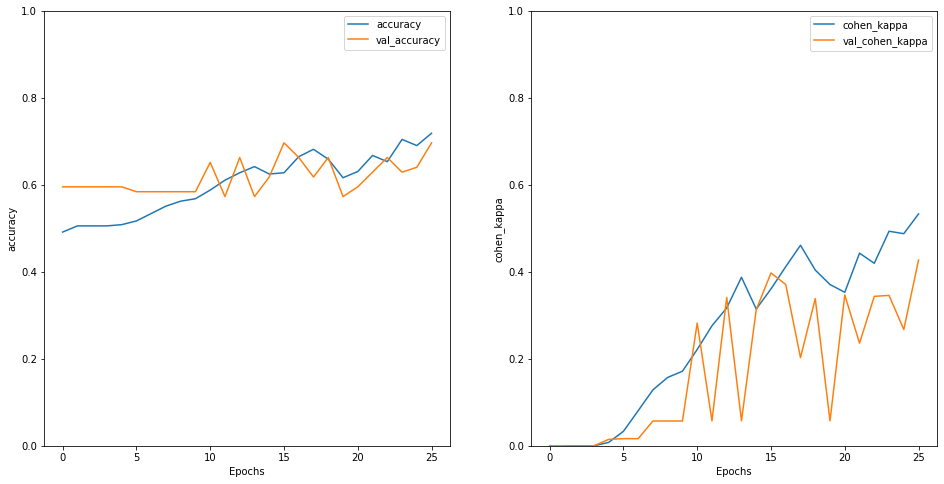

In [98]:
test_acc_enc = m_enc.evaluate(x_test, y_test)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_enc, 'accuracy')
plt.ylim(0, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_enc, 'cohen_kappa')
plt.ylim(0, 1)

In [122]:
# save this result
Model = 'TransformerEncoder'
config_name = 'Transformer Encoder, no text augmentation'

param = {'vocab_size': vocab_size, 'embed_dim':embed_dim
         , 'maxlen':maxlen, 'num_aug': 'None'}
results = {'Loss':test_acc_enc[0], 'Accuracy':test_acc_enc[1], 'F1':test_acc_enc[2], 'Kappa':test_acc_enc[3]}
storage.update({Model: {'config':config_name, 'parameters':param, 'duration':timediff, 'results': results}})

print(storage.keys())
list(storage.items())

dict_keys(['BiLSTM_aug_3', 'TransformerEncoder'])


[('BiLSTM_aug_3',
  {'config': 'num_aug = 3',
   'parameters': {'vocab_size': 1040,
    'embed_dim': 4,
    'maxlen': 50,
    'num_aug': 3},
   'duration': 16.601496696472168,
   'results': {'Loss': 0.8465606570243835,
    'Accuracy': 0.7142857313156128,
    'F1': 0.7033319473266602,
    'Kappa': 0.5093098878860474}}),
 ('TransformerEncoder',
  {'config': 'Transformer Encoder, no text augmentation',
   'parameters': {'vocab_size': 1040,
    'embed_dim': 4,
    'maxlen': 50,
    'num_aug': 'None'},
   'duration': 16.601496696472168,
   'results': {'Loss': 0.9209188222885132,
    'Accuracy': 0.6966292262077332,
    'F1': 0.6611249446868896,
    'Kappa': 0.4273117780685425}})]

In [104]:
pred = m_enc.predict(x_test)
label_pred_enc = np.argmax(pred, axis=1)
cm_enc = confusion_matrix(y_true=labels, y_pred=label_pred_enc)
report_enc = classification_report(labels, label_pred_enc)
print('Confusion Matrix:\n', cm_enc, '\nClassification rreport:\n', report_enc)

Confusion Matrix:
 [[ 0  0  3  7]
 [ 0 11  2  8]
 [ 0  1  3  1]
 [ 0  1  4 48]] 
Classification rreport:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.85      0.52      0.65        21
           2       0.25      0.60      0.35         5
           3       0.75      0.91      0.82        53

    accuracy                           0.70        89
   macro avg       0.46      0.51      0.46        89
weighted avg       0.66      0.70      0.66        89



C:\Users\erwang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erwang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erwang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


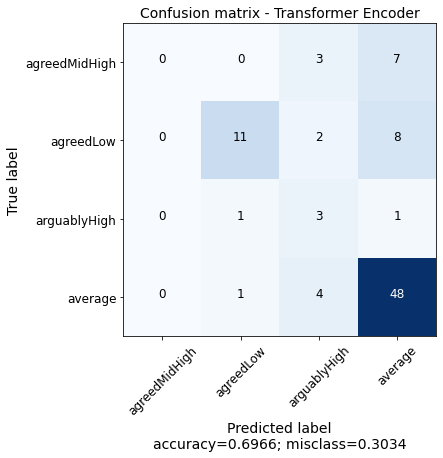

In [106]:
# plot confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_enc, target_names=targetlabel, title='Confusion matrix - Transformer Encoder', normalize=False)

ROC AUC score: 0.6810588543593539


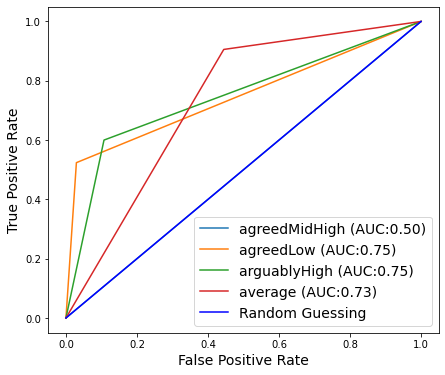

In [345]:
# plot AUC
fig, c_ax = plt.subplots(1,1,figsize = (7, 6))
auc_enc = multiclass_roc_auc_score(labels, label_pred_enc)
print('ROC AUC score:', auc_enc)
c_ax.legend(fontsize=14)
c_ax.set_xlabel('False Positive Rate', fontsize=14)
c_ax.set_ylabel('True Positive Rate', fontsize=14)
plt.show()

# Model - BiLSTM with text augmentation

**num_aug = 3, 8, 16**

In [348]:
num_aug = 16
df_aug = [i.strip('\n').split('\t') for i in open('./eda_nlp-master/maths_response_augmented%i.txt' %num_aug)]
df_aug = pd.DataFrame(df_aug, columns=['label', 'clean_text'])
print('before dedup:', df_aug.shape)
df_aug.drop_duplicates(inplace=True)
print('after dedup:', df_aug.shape)

before dedup: (7056, 2)
after dedup: (5209, 2)


vacab_size: 1606
X shape: (5209, 50) 
 4    2775
2     930
1     769
3     735
Name: label, dtype: int64


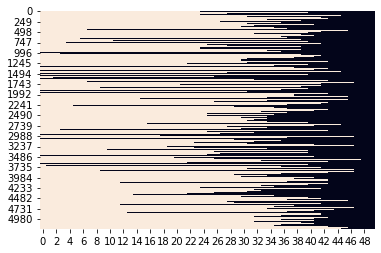

x_train shape: (4167, 50)	y_train shape: (4167, 4)
x_test shape: (1042, 50)	y_test shape: (1042, 4)



In [352]:
# Set parameters
maxlen = 50

# get tokenizer
tokenizer = Tokenizer(num_words=max_vocab_size, lower=True, oov_token=True)
tokenizer.fit_on_texts(df_aug['clean_text'])
vocab_size = len(tokenizer.index_word)
print('vacab_size:', vocab_size)

# get X
X_seq = tokenizer.texts_to_sequences(df_aug['clean_text'].values)
X = pad_sequences(X_seq, maxlen)

# get Y
Y = pd.get_dummies(df_aug['label']).values
print('X shape:', X.shape, '\n', df_aug['label'].value_counts())

sns.heatmap(X==0, vmin=0, vmax=1, cbar=False)
plt.show()

# split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=420)
print('x_train shape: {}\ty_train shape: {}\nx_test shape: {}\ty_test shape: {}\n'.format(
    x_train.shape, y_train.shape, x_test.shape, y_test.shape))

# prepare for maping from cluster labels [1,2,3,4] to target labels
labels_aug = np.argmax(y_test, axis=1)
targetlabel = ['agreedMidHigh', 'agreedLow', 'arguablyHigh','average']

In [173]:
# vocabulary size = 510 words
embed_dim = 4 # shape(x) = 4
# RNN model with LSTM
m_bilstm = Sequential()
m_bilstm.add(Embedding(vocab_size+1, output_dim=embed_dim, input_length=maxlen))
#m_bilstm.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1))
m_bilstm.add(Bidirectional(LSTM(64)))
m_bilstm.add(Dense(64, activation='relu'))
m_bilstm.add(Dense(4, activation='softmax'))

# compile
m_bilstm.compile(optimizer='adam' # Adam(learning_rate=0.0005) 
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy', tfa.metrics.F1Score(num_classes=4, average='weighted')
                             , tfa.metrics.CohenKappa(num_classes=4)])
print(vocab_size+1, embed_dim, maxlen)
print(m_bilstm.summary())

1607 4 50
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 50, 4)             6428      
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              35328     
 nal)                                                            
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 4)                 260       
                                                                 
Total params: 50,272
Trainable params: 50,272
Non-trainable params: 0
_________________________________________________________________
None


In [174]:
# train
num_epoch = 15
if num_aug == 3:
    threshold = 0.5 # kappa threshold
elif num_aug == 8:
    threshold = 0.6 # kappa
elif num_aug == 16:
    threshold = 0.7 # kappa
callbacks=myCallback()
time0=time()
globals()[f'history_bilstm_aug_%i'%num_aug] = m_bilstm.fit(x_train, y_train, epochs=num_epoch
                       # , validation_steps=15
                       , validation_data=(x_test, y_test)
                        , callbacks=[callbacks]
                       )
timediff = time()-time0
history_bilstm = globals()[f'history_bilstm_aug_%i'%num_aug]
print(timediff)

Epoch 1/15
131/131 [==============================] - 9s 35ms/step - loss: 1.1677 - accuracy: 0.5472 - f1_score: 0.4057 - cohen_kappa: 0.0486 - val_loss: 1.0902 - val_accuracy: 0.5787 - val_f1_score: 0.4617 - val_cohen_kappa: 0.2431
Epoch 2/15
131/131 [==============================] - 4s 29ms/step - loss: 0.9688 - accuracy: 0.6242 - f1_score: 0.5122 - cohen_kappa: 0.2875 - val_loss: 0.9120 - val_accuracy: 0.6699 - val_f1_score: 0.6219 - val_cohen_kappa: 0.4274
Epoch 3/15
131/131 [==============================] - 4s 29ms/step - loss: 0.8193 - accuracy: 0.6892 - f1_score: 0.6529 - cohen_kappa: 0.4524 - val_loss: 0.7406 - val_accuracy: 0.7255 - val_f1_score: 0.7182 - val_cohen_kappa: 0.5545
Epoch 4/15
131/131 [==============================] - 5s 39ms/step - loss: 0.7051 - accuracy: 0.7367 - f1_score: 0.7252 - cohen_kappa: 0.5591 - val_loss: 0.7432 - val_accuracy: 0.7121 - val_f1_score: 0.7101 - val_cohen_kappa: 0.5482
Epoch 5/15
131/131 [==============================] - 5s 36ms/step -

33/33 [==============================] - 0s 11ms/step - loss: 0.5228 - accuracy: 0.8119 - f1_score: 0.8093 - cohen_kappa: 0.7043


(0.0, 0.7370412439107895)

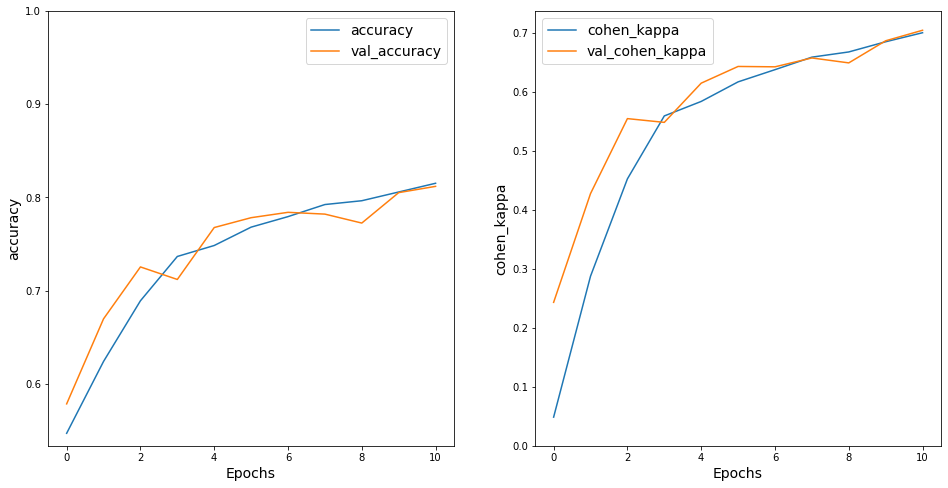

In [175]:
globals()[f'test_acc_aug_%i'%num_aug] = m_bilstm.evaluate(x_test, y_test)
test_acc_bilstm_aug = globals()[f'test_acc_aug_%i'%num_aug]

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_bilstm, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_bilstm, 'cohen_kappa')
plt.ylim(0, None)

In [176]:
# save this result
Model = 'BiLSTM_aug_%i' %num_aug
config_name = 'num_aug = %i' %num_aug

param = {'vocab_size': vocab_size, 'embed_dim':embed_dim
         , 'maxlen':maxlen, 'num_aug': num_aug}
results = {'Loss':test_acc_bilstm_aug[0], 'Accuracy':test_acc_bilstm_aug[1], 'F1':test_acc_bilstm_aug[2], 'Kappa':test_acc_bilstm_aug[3]}
storage.update({Model: {'config':config_name, 'parameters':param, 'duration':timediff, 'results': results}})

print(storage.keys())
list(storage.items())

dict_keys(['BiLSTM_aug_3', 'TransformerEncoder', 'BiLSTM', 'TransformerEncoder_aug_3', 'BiLSTM_aug_8', 'TransformerEncoder_aug_8', 'BiLSTM_aug_16'])


[('BiLSTM_aug_3',
  {'config': 'num_aug = 3',
   'parameters': {'vocab_size': 1040,
    'embed_dim': 4,
    'maxlen': 50,
    'num_aug': 3},
   'duration': 16.601496696472168,
   'results': {'Loss': 0.8465606570243835,
    'Accuracy': 0.7142857313156128,
    'F1': 0.7033319473266602,
    'Kappa': 0.5093098878860474}}),
 ('TransformerEncoder',
  {'config': 'Transformer Encoder, no text augmentation',
   'parameters': {'vocab_size': 1040,
    'embed_dim': 4,
    'maxlen': 50,
    'num_aug': 'None'},
   'duration': 16.601496696472168,
   'results': {'Loss': 0.9209188222885132,
    'Accuracy': 0.6966292262077332,
    'F1': 0.6611249446868896,
    'Kappa': 0.4273117780685425}}),
 ('BiLSTM',
  {'config': 'Bidirectional LSTM, no text augmentation',
   'parameters': {'vocab_size': 1040,
    'embed_dim': 4,
    'maxlen': 50,
    'num_aug': 'None'},
   'duration': 16.601496696472168,
   'results': {'Loss': 0.9426203370094299,
    'Accuracy': 0.6966292262077332,
    'F1': 0.6547823548316956,
    

In [177]:
pred = m_bilstm.predict(x_test)
globals()[f'label_pred_bilstm_aug_%i'%num_aug] = np.argmax(pred, axis=1)
label_pred_bilstm_aug = globals()[f'label_pred_bilstm_aug_%i'%num_aug]
globals()[f'cm_bilstm_aug_%i'%num_aug] = confusion_matrix(y_true=labels, y_pred=label_pred_bilstm_aug)
globals()[f'report_bilstm_aug_%i'%num_aug] = classification_report(labels, label_pred_bilstm_aug)
print('Confusion Matrix:\n', globals()[f'cm_bilstm_aug_%i'%num_aug]
      , '\nClassification rreport:\n', globals()[f'report_bilstm_aug_%i'%num_aug])

Confusion Matrix:
 [[ 95   3   6  56]
 [  6 146   0  33]
 [  7   4 125  23]
 [ 18  40   0 480]] 
Classification rreport:
               precision    recall  f1-score   support

           0       0.75      0.59      0.66       160
           1       0.76      0.79      0.77       185
           2       0.95      0.79      0.86       159
           3       0.81      0.89      0.85       538

    accuracy                           0.81      1042
   macro avg       0.82      0.77      0.79      1042
weighted avg       0.81      0.81      0.81      1042



In [160]:
#print(cm_bilstm_aug16)

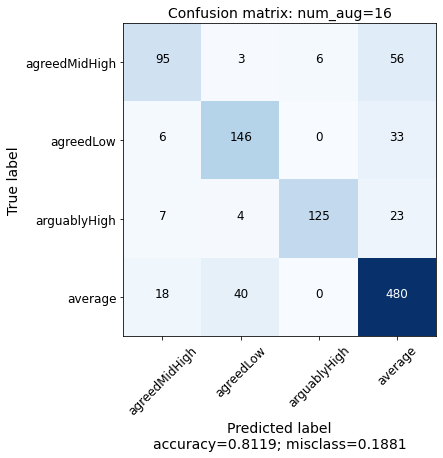

In [179]:
# plot confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(globals()[f'cm_bilstm_aug_%i'%num_aug], target_names=targetlabel, title='Confusion matrix: num_aug=%i'%num_aug, normalize=False)

ROC AUC score - num_aug=16: 0.8427861143132894


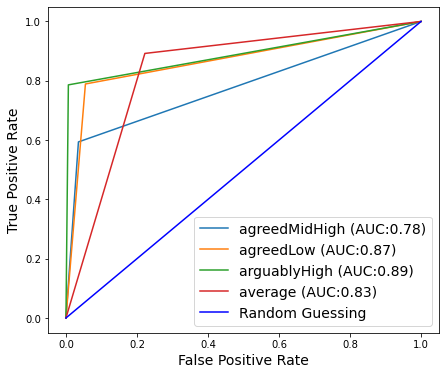

In [180]:
# plot AUC
fig, c_ax = plt.subplots(1,1, figsize = (7, 6))
print('ROC AUC score - num_aug=%i:'%num_aug, multiclass_roc_auc_score(labels_aug, label_pred_bilstm_aug))
c_ax.legend(fontsize=14)
c_ax.set_xlabel('False Positive Rate', fontsize=14)
c_ax.set_ylabel('True Positive Rate', fontsize=14)
plt.show()

# Model - Transformer Encoder with text augmentation

In [191]:
embed_dim_ = 5  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size+1, embed_dim_) # embedding + positioning
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim_, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)

m_enc_aug = keras.Model(inputs=inputs, outputs=outputs)

# train and evaluate
m_enc_aug.compile(optimizer='adam' # Adam(learning_rate =0.0009) # , decay=0.00001
                     , loss="categorical_crossentropy"
                     , metrics=['accuracy'
                             , tfa.metrics.F1Score(num_classes=4, average='weighted')
                             , tfa.metrics.CohenKappa(num_classes=4)
                            #   , METRICS
                               ])
print(vocab_size+1, embed_dim, maxlen)
print(m_bilstm.summary())

1607 4 50
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 50, 4)             6428      
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              35328     
 nal)                                                            
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 4)                 260       
                                                                 
Total params: 50,272
Trainable params: 50,272
Non-trainable params: 0
_________________________________________________________________
None


In [192]:
num_epoch = 15
if num_aug == 3:
    threshold = 0.5 # kappa threshold
elif num_aug == 8:
    threshold = 0.6 # kappa
elif num_aug == 16:
    threshold = 0.7 # kappa
time0=time()
globals()[f'history_enc_aug_%i'%num_aug] = m_enc_aug.fit(x_train, y_train, epochs=num_epoch,
                  #  validation_steps=15,
                    validation_data=(x_test, y_test), callbacks=[callbacks])
timediff = time()-time0
history_enc_aug = globals()[f'history_enc_aug_%i'%num_aug]
print(timediff)

Epoch 1/15
131/131 [==============================] - 3s 11ms/step - loss: 1.1408 - accuracy: 0.5618 - f1_score: 0.4282 - cohen_kappa: 0.0885 - val_loss: 1.0632 - val_accuracy: 0.5960 - val_f1_score: 0.4842 - val_cohen_kappa: 0.2240
Epoch 2/15
131/131 [==============================] - 1s 7ms/step - loss: 0.9443 - accuracy: 0.6283 - f1_score: 0.5306 - cohen_kappa: 0.2853 - val_loss: 0.9245 - val_accuracy: 0.6305 - val_f1_score: 0.5454 - val_cohen_kappa: 0.2962
Epoch 3/15
131/131 [==============================] - 1s 7ms/step - loss: 0.7911 - accuracy: 0.6909 - f1_score: 0.6541 - cohen_kappa: 0.4533 - val_loss: 0.7232 - val_accuracy: 0.7217 - val_f1_score: 0.6970 - val_cohen_kappa: 0.5251
Epoch 4/15
131/131 [==============================] - 1s 7ms/step - loss: 0.7013 - accuracy: 0.7310 - f1_score: 0.7129 - cohen_kappa: 0.5428 - val_loss: 0.6406 - val_accuracy: 0.7601 - val_f1_score: 0.7476 - val_cohen_kappa: 0.6028
Epoch 5/15
131/131 [==============================] - 1s 6ms/step - los

33/33 [==============================] - 0s 4ms/step - loss: 0.5128 - accuracy: 0.8138 - f1_score: 0.8074 - cohen_kappa: 0.7023


(0.0, 0.7534652322530746)

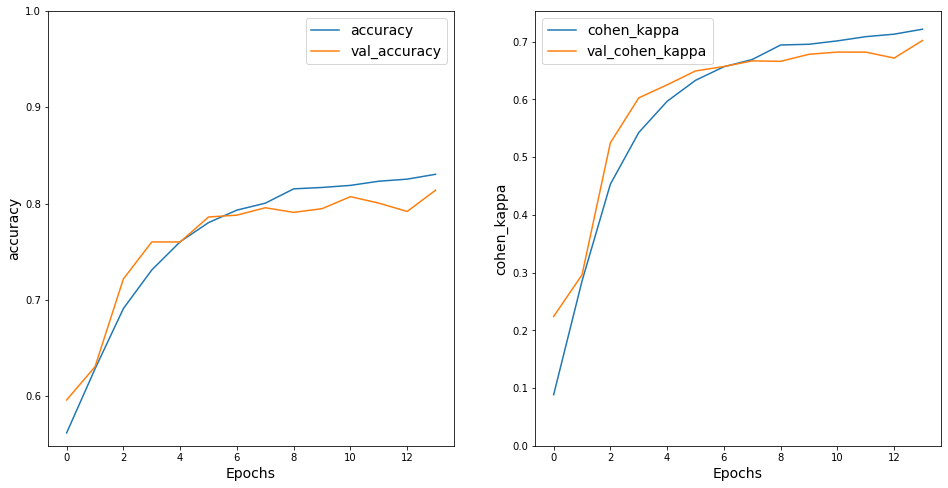

In [193]:
globals()[f'test_acc_enc_aug_%i'%num_aug] = m_enc_aug.evaluate(x_test, y_test)
test_acc_enc_aug = globals()[f'test_acc_enc_aug_%i'%num_aug]

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_enc_aug, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_enc_aug, 'cohen_kappa')
plt.ylim(0, None)

In [194]:
# save this result
Model = 'TransformerEncoder_aug_%i' %num_aug
config_name = 'num_aug = %i' %num_aug

param = {'vocab_size': vocab_size, 'embed_dim':embed_dim
         , 'maxlen':maxlen, 'num_aug': num_aug}
results = {'Loss':test_acc_enc_aug[0], 'Accuracy':test_acc_enc_aug[1], 'F1':test_acc_enc_aug[2], 'Kappa':test_acc_enc_aug[3]}
storage.update({Model: {'config':config_name, 'parameters':param, 'duration':timediff, 'results': results}})

print(storage.keys())
list(storage.items())

dict_keys(['BiLSTM_aug_3', 'TransformerEncoder', 'BiLSTM', 'TransformerEncoder_aug_3', 'BiLSTM_aug_8', 'TransformerEncoder_aug_8', 'BiLSTM_aug_16', 'TransformerEncoder_aug_16'])


[('BiLSTM_aug_3',
  {'config': 'num_aug = 3',
   'parameters': {'vocab_size': 1040,
    'embed_dim': 4,
    'maxlen': 50,
    'num_aug': 3},
   'duration': 16.601496696472168,
   'results': {'Loss': 0.8465606570243835,
    'Accuracy': 0.7142857313156128,
    'F1': 0.7033319473266602,
    'Kappa': 0.5093098878860474}}),
 ('TransformerEncoder',
  {'config': 'Transformer Encoder, no text augmentation',
   'parameters': {'vocab_size': 1040,
    'embed_dim': 4,
    'maxlen': 50,
    'num_aug': 'None'},
   'duration': 16.601496696472168,
   'results': {'Loss': 0.9209188222885132,
    'Accuracy': 0.6966292262077332,
    'F1': 0.6611249446868896,
    'Kappa': 0.4273117780685425}}),
 ('BiLSTM',
  {'config': 'Bidirectional LSTM, no text augmentation',
   'parameters': {'vocab_size': 1040,
    'embed_dim': 4,
    'maxlen': 50,
    'num_aug': 'None'},
   'duration': 16.601496696472168,
   'results': {'Loss': 0.9426203370094299,
    'Accuracy': 0.6966292262077332,
    'F1': 0.6547823548316956,
    

In [327]:
pred_enc_aug = m_enc_aug.predict(x_test)
globals()[f'label_pred_enc_aug_%i'%num_aug] = np.argmax(pred_enc_aug, axis=1)
label_pred_enc_aug = globals()[f'label_pred_enc_aug_%i'%num_aug]
globals()[f'cm_enc_aug_%i'%num_aug] = confusion_matrix(y_true=labels, y_pred=label_pred_enc_aug)
globals()[f'report_enc_aug_%i'%num_aug] = classification_report(labels, label_pred_enc_aug)
print('Confusion Matrix:\n', globals()[f'cm_enc_aug_%i'%num_aug], '\nClassification rreport:\n', globals()[f'report_enc_aug_%i'%num_aug])

Confusion Matrix:
 [[ 83   1   8  68]
 [  2 138   0  45]
 [  3   4 134  18]
 [  8  31   6 493]] 
Classification rreport:
               precision    recall  f1-score   support

           0       0.86      0.52      0.65       160
           1       0.79      0.75      0.77       185
           2       0.91      0.84      0.87       159
           3       0.79      0.92      0.85       538

    accuracy                           0.81      1042
   macro avg       0.84      0.76      0.78      1042
weighted avg       0.82      0.81      0.81      1042



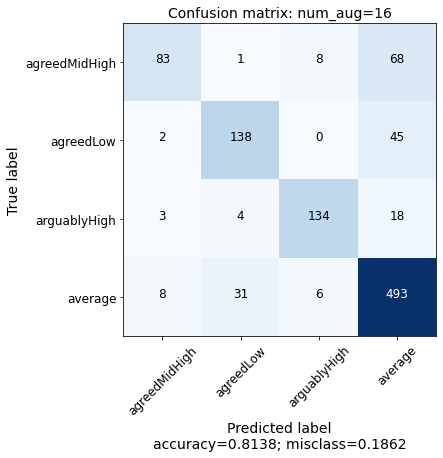

In [328]:
# plot confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(globals()[f'cm_enc_aug_%i'%num_aug], target_names=targetlabel, title='Confusion matrix: num_aug=%i'%num_aug, normalize=False)

ROC AUC score: 0.8364122767646015


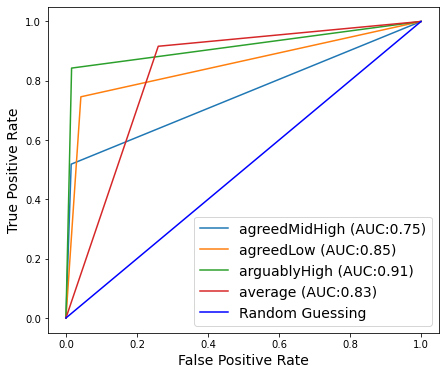

In [353]:
# plot AUC
fig, c_ax = plt.subplots(1,1, figsize = (7, 6))
globals()[f'auc_enc_aug_%i'%num_aug] = multiclass_roc_auc_score(labels_aug, label_pred_enc_aug)
print('ROC AUC score:', globals()[f'auc_enc_aug_%i'%num_aug])
c_ax.legend(fontsize=14)
c_ax.set_xlabel('False Positive Rate', fontsize=14)
c_ax.set_ylabel('True Positive Rate', fontsize=14)
plt.show()

In [119]:
json.dump(storage, open('./log/storage_aug.json', 'w'))

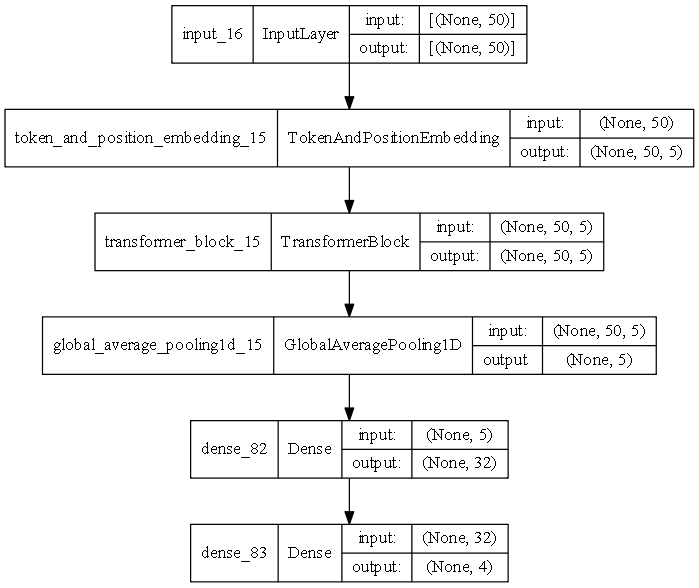

In [120]:
keras.utils.plot_model(m_enc_aug, show_shapes=True, dpi=90)

# Results

Text(0.5, 1.0, 'M1_x16')

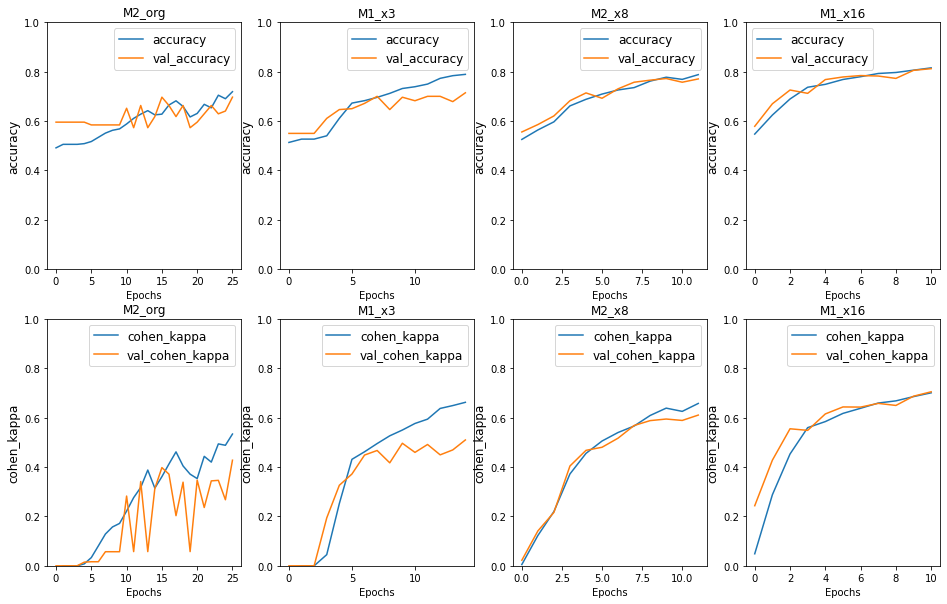

In [389]:
plt.figure(figsize=(16, 10))

# acc
plt.subplot(2, 4, 1)
plot_graphs(history_enc, 'accuracy')
plt.ylim(0, 1)
plt.title('M2_org', fontsize=12)
# kappa
plt.subplot(2, 4, 5)
plot_graphs(history_enc, 'cohen_kappa')
plt.ylim(0, 1)
plt.title('M2_org', fontsize=12)

# acc
plt.subplot(2, 4, 2)
plot_graphs(history_bilstm_aug_3, 'accuracy')
plt.ylim(0, 1)
plt.title('M1_x3', fontsize=12)
# kappa
plt.subplot(2, 4, 6)
plot_graphs(history_bilstm_aug_3, 'cohen_kappa')
plt.ylim(0, 1)
plt.title('M1_x3', fontsize=12)

# acc
plt.subplot(2, 4, 3)
plot_graphs(history_enc_aug_8, 'accuracy')
plt.ylim(0, 1)
plt.title('M2_x8', fontsize=12)
# kappa
plt.subplot(2, 4, 7)
plot_graphs(history_enc_aug_8, 'cohen_kappa')
plt.ylim(0, 1)
plt.title('M2_x8', fontsize=12)

# acc
plt.subplot(2, 4, 4)
plot_graphs(history_bilstm_aug_16, 'accuracy')
plt.ylim(0, 1)
plt.title('M1_x16', fontsize=12)
# kappa
plt.subplot(2, 4, 8)
plot_graphs(history_bilstm_aug_16, 'cohen_kappa')
plt.ylim(0, 1)
plt.title('M1_x16', fontsize=12)

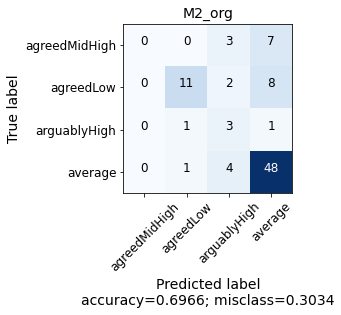

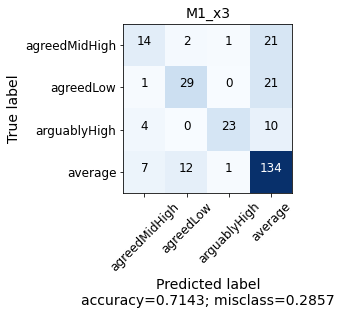

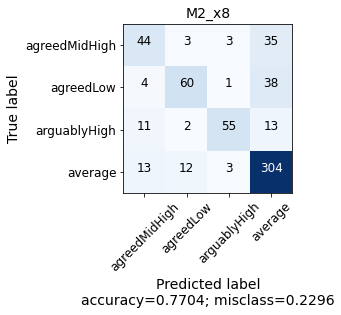

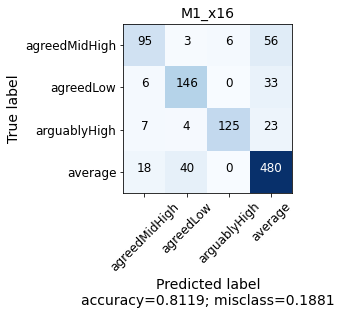

In [391]:
#fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4)

#plt.figure(figsize=(8,6))
#plt.subplot(2, 2, 1)
p1=plot_confusion_matrix(cm_enc, target_names=targetlabel, 
                      title='M2_org', normalize=False)
# #plt.subplot(2, 2, 2)
p2=plot_confusion_matrix(cm_bilstm_aug_3, target_names=targetlabel, 
                       title='M1_x3', normalize=False)
# #plt.subplot(2, 2, 3)
p3=plot_confusion_matrix(cm_enc_aug_8, target_names=targetlabel, 
                       title='M2_x8', normalize=False)
# #plt.subplot(2, 2, 4)
p4=plot_confusion_matrix(cm_bilstm_aug_16, target_names=targetlabel, 
                       title='M1_x16', normalize=False)

ROC AUC score: 0.6810588543593539


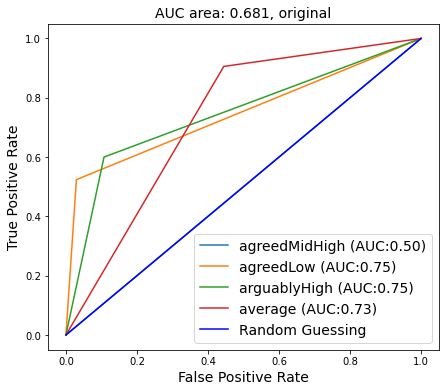

In [386]:
fig, c_ax = plt.subplots(1,1, figsize=(7,6))
print('ROC AUC score:', multiclass_roc_auc_score(labels, label_pred_enc))
c_ax.legend(fontsize=14)
c_ax.set_xlabel('False Positive Rate', fontsize=14)
c_ax.set_ylabel('True Positive Rate', fontsize=14)
plt.title('AUC area: 0.681, original',fontsize=14)
plt.show()

ROC AUC score: 0.8364122767646015


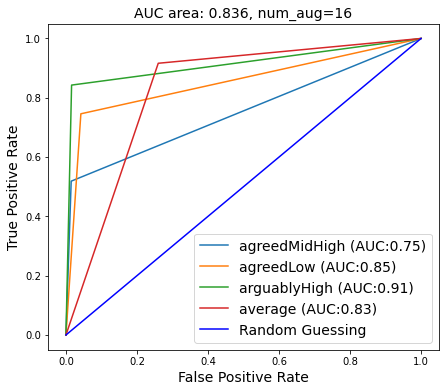

In [387]:
fig, c_ax = plt.subplots(1,1, figsize=(7,6))
print('ROC AUC score:', multiclass_roc_auc_score(labels_aug, label_pred_enc_aug_16))
c_ax.legend(fontsize=14)
c_ax.set_xlabel('False Positive Rate', fontsize=14)
c_ax.set_ylabel('True Positive Rate', fontsize=14)
plt.title('AUC area: 0.836, num_aug=16', fontsize=14)
plt.show()

In [396]:
print(report_enc) # M2_org
print(report_bilstm_aug_3) # M1_x3
print(report_enc_aug_8) # M2_x8
print(report_bilstm_aug_16) # M1_x16

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.85      0.52      0.65        21
           2       0.25      0.60      0.35         5
           3       0.75      0.91      0.82        53

    accuracy                           0.70        89
   macro avg       0.46      0.51      0.46        89
weighted avg       0.66      0.70      0.66        89

              precision    recall  f1-score   support

           0       0.54      0.37      0.44        38
           1       0.67      0.57      0.62        51
           2       0.92      0.62      0.74        37
           3       0.72      0.87      0.79       154

    accuracy                           0.71       280
   macro avg       0.71      0.61      0.65       280
weighted avg       0.71      0.71      0.70       280

              precision    recall  f1-score   support

           0       0.61      0.52      0.56        85
           1       0.

----------------------------------------------------------------------------------------------------------------------
**END**